In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import math
%matplotlib inline

# Standard imports
import numpy as np

#Data scraping

In [ ]:
# URL to the yahoo finance history for Bayer stock
url_BNTX = 'https://finance.yahoo.com/quote/BNTX/history?period1=1688947200&period2=1696896000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
url_BAYRY = 'https://finance.yahoo.com/quote/BAYRY/history?period1=1688947200&period2=1696896000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'

def scrpr_yahoo_finance(url):


    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/116.0'}

    #requesting the text from the website using the request module
    html_text = requests.get(url, headers = headers).text
    #using beautiful soup for accesibility
    soup = BeautifulSoup(html_text, 'lxml')

    #creating the dataFrame to save the data into
    df = pd.DataFrame(columns=['Date', 'Price', 'High', 'Low', 'Volume'])

    #scraping the data for bayer historical stock info for the last 6months
    for i in range(65):

        date = soup.find_all('td', class_ ='Py(10px) Ta(start) Pend(10px)')[i].find('span').text
        close = soup.find_all('tr', class_ ='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')[i].find_all('td', class_ = 'Py(10px) Pstart(10px)')[3].find('span').text
        day_low = soup.find_all('tr', class_ ='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')[i].find_all('td', class_ = 'Py(10px) Pstart(10px)')[2].find('span').text
        day_high = soup.find_all('tr', class_ ='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')[i].find_all('td', class_ = 'Py(10px) Pstart(10px)')[1].find('span').text
        #ganz wichitg wir müssen den 0ten iterieren für beides close UND volume
        volume = soup.find_all('tr', class_ ='BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)')[i].find_all('td', class_ = 'Py(10px) Pstart(10px)')[5].find('span').text
        volume = volume.replace(",","")
        #df = df.append({'Numbers': date, 'ClosingPrice': close, 'Volume': volume}, ignore_index= True)
        df = pd.concat([df, pd.DataFrame({'Date': date, 'Price': float(close),'Low': float(day_low),'High': float(day_high), 'Volume': int(volume)}, index= [i])], ignore_index=True)
        #print (date, close, volume)
    return (df)


df_BNTX = scrpr_yahoo_finance(url_BNTX)
df_BAYRY = scrpr_yahoo_finance(url_BAYRY)



print (df_BNTX)
print (df_BAYRY)
rerun_flag = 0 #this flag is thrown to show that the data cleaning is necessary

            Date   Price    High     Low  Volume
0   Oct 09, 2023  109.31  110.40  107.50  450700
1   Oct 06, 2023  111.21  112.37  109.03  520200
2   Oct 05, 2023  109.85  111.43  107.60  498300
3   Oct 04, 2023  110.24  110.45  107.26  576500
4   Oct 03, 2023  109.33  112.00  107.72  692800
..           ...     ...     ...     ...     ...
60  Jul 14, 2023  108.24  110.41  108.11  516400
61  Jul 13, 2023  109.51  110.31  108.96  543300
62  Jul 12, 2023  109.00  110.24  108.18  557700
63  Jul 11, 2023  107.90  108.72  106.74  455300
64  Jul 10, 2023  107.43  108.92  107.14  481300

[65 rows x 5 columns]
            Date  Price   High    Low   Volume
0   Oct 09, 2023  11.54  11.56  11.38   418900
1   Oct 06, 2023  11.64  11.69  11.45  1215500
2   Oct 05, 2023  11.58  11.59  11.45   571100
3   Oct 04, 2023  11.65  11.67  11.55   690600
4   Oct 03, 2023  11.46  11.59  11.43   959700
..           ...    ...    ...    ...      ...
60  Jul 14, 2023  14.11  14.14  14.04   420300
61  Jul 13, 2

# Data cleaning

In [ ]:
print (rerun_flag)

def data_cleaning(df_internal):
    #This separation is done so that the code snipplets can be run independently.
    #This part, the DataFrame formating,
    #format the 'Date' column to a more readable format
    df_internal['Date'] = pd.to_datetime(df_internal['Date'])
    #df2.set_index('Date', inplace=True) # this one would also change the original DataFrame - convenient but not what i want
    # making the 'Date' column the index colum for manipulation
    df_internal = df_internal.set_index('Date')
    #declare the beginning and end of the dataset - prep for adding daily data
    startdate = df_internal.index.min()
    enddate = df_internal.index.max()
    date_range=pd.date_range(start=startdate, end=enddate, freq='D')
    # adding the data continous to show that I can manipulate the data. Initializing/adding the weekend days/holidays
    df_internal = df_internal.reindex(date_range, fill_value= 0)
    #change the data back to an numbered index and renaming the 'Date' column back to 'Date'
    df_internal = df_internal.reset_index()
    df_internal = df_internal.rename(columns={'index': 'Date'})

    for date in df_internal.index:
        if df_internal.at[date, 'Price'] == 0:
            prev_day = df_internal[df_internal.index < date].tail(3)
            roll_Mean = prev_day['Price'].mean()
            roll_Mean_low = prev_day['Low'].mean()
            roll_Mean_high = prev_day['High'].mean()
            roll_Vol = int(prev_day['Volume'].mean())
            df_internal.at[date, 'Price'] = roll_Mean
            df_internal.at[date, 'Low'] = roll_Mean_low
            df_internal.at[date, 'High'] = roll_Mean_high
            df_internal.at[date, 'Volume'] = roll_Vol

    return (df_internal)

if rerun_flag == 0:

    df_BNTX = data_cleaning(df_BNTX)
    df_BAYRY = data_cleaning(df_BAYRY)
    rerun_flag = 1


print (df_BNTX.head(30))
print (df_BAYRY.head(30))
print (rerun_flag)
df_BAYRY.reset_index(inplace=True)
df_BNTX.reset_index(inplace=True)

0
         Date       Price        High         Low   Volume
0  2023-07-10  107.430000  108.920000  107.140000   481300
1  2023-07-11  107.900000  108.720000  106.740000   455300
2  2023-07-12  109.000000  110.240000  108.180000   557700
3  2023-07-13  109.510000  110.310000  108.960000   543300
4  2023-07-14  108.240000  110.410000  108.110000   516400
5  2023-07-15  108.916667  110.320000  108.416667   539133
6  2023-07-16  108.888889  110.346667  108.495556   532944
7  2023-07-17  107.210000  108.770000  106.940000   498000
8  2023-07-18  108.150000  109.160000  107.480000   448100
9  2023-07-19  109.130000  110.190000  107.900000   632900
10 2023-07-20  107.720000  109.560000  107.600000   487200
11 2023-07-21  108.590000  109.530000  106.580000   679000
12 2023-07-22  108.480000  109.760000  107.360000   599700
13 2023-07-23  108.263333  109.616667  107.180000   588633
14 2023-07-24  107.030000  108.700000  106.120000   619600
15 2023-07-25  106.860000  109.650000  106.670000   62

In [ ]:
#print(df.head(40))
#print(df.tail(40))
print(rerun_flag)

1


# Price Trends of the two Stocks over time

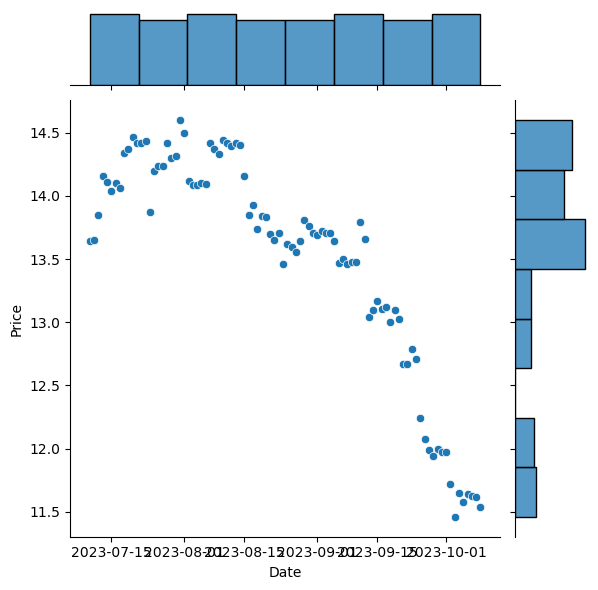

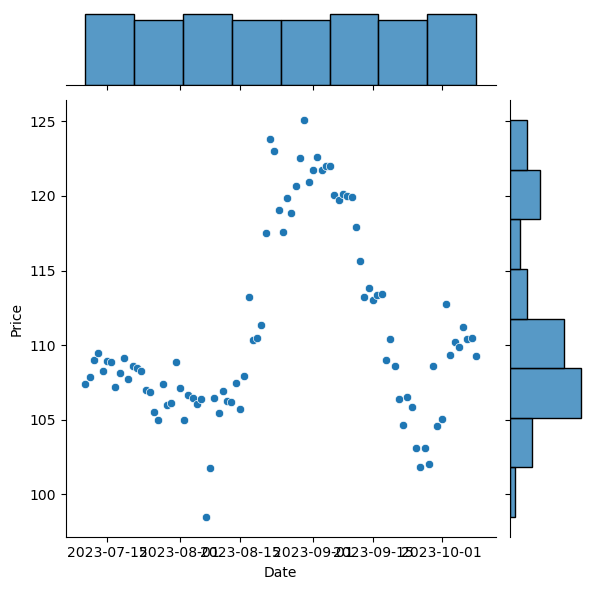

In [ ]:
sns.jointplot(x='Date', y='Price', data=df_BAYRY)
sns.jointplot(x='Date', y='Price', data=df_BNTX)

# Closing Price Trends

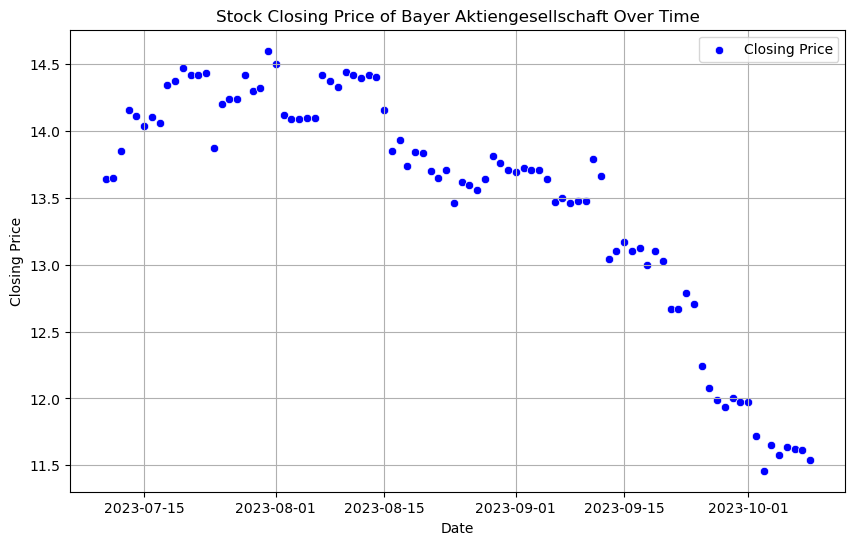

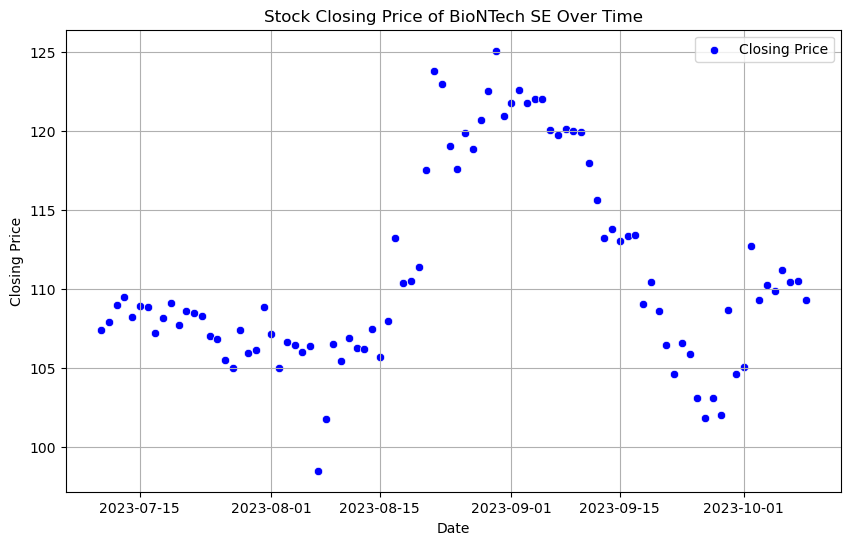

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_BAYRY, x='Date', y='Price', label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Price of Bayer Aktiengesellschaft Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_BNTX, x='Date', y='Price', label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Price of BioNTech SE Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# EDA analysis : Descriptive statistics


In [ ]:
# Define the desired months as a list from July to October (7 to 10)
desired_months = [7, 8, 9, 10]
print(df_BAYRY.columns)
# Create an empty DataFrame to store the results
results_df = pd.DataFrame()
df_BAYRY['Date'] = pd.to_datetime(df_BAYRY['Date'])

for desired_month in desired_months:
    # Filter the original DataFrame for the specific month
    filtered_df = df_BAYRY[df_BAYRY['Date'].dt.month == desired_month]
    #print(df['Volume'].dtype)

    # Calculate and store the required statistics
    mean_volume = filtered_df['Volume'].mean()
    median_volume = filtered_df['Volume'].median()
    mode_volume = filtered_df['Volume'].mode()
    std_volume = filtered_df['Volume'].std()

    #filtered_df['Price'] = pd.to_numeric(filtered_df['Price'], errors='coerce')
    mean_closing_price = filtered_df['Price'].mean()
    median_closing_price = filtered_df['Price'].median()
    mode_closing_price = filtered_df['Price'].mode()
    std_closing_price = filtered_df['Price'].std()

    # Create a dictionary to store the results for the month
    month_result = {
        'Month': calendar.month_name[desired_month],
        'Mean_Volume': mean_volume,
        'Median_Volume': median_volume,
        'Mode_Volume': mode_volume.values[0] if not mode_volume.empty else None,
        'Std_Volume': std_volume,
        'Mean_Price': mean_closing_price,
        'Median_Price': median_closing_price,
        'Mode_Price': mode_closing_price.values[0] if not mode_closing_price.empty else None,
        'Std_Price': std_closing_price
    }

    # Append the month's results to the results DataFrame
    month_result_df = pd.DataFrame([month_result])

    # Concatenate the DataFrames
    results_df = pd.concat([results_df, month_result_df], ignore_index=True)

# Print the results DataFrame
print(results_df)


# Define the desired months as a list from July to October (7 to 10)
desired_months = [7, 8, 9, 10]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame()
df_BNTX['Date'] = pd.to_datetime(df_BNTX['Date'])
for desired_month in desired_months:
    # Filter the original DataFrame for the specific month
    filtered_df = df_BNTX[df_BNTX['Date'].dt.month == desired_month]
    #print(df['Volume'].dtype)

    # Calculate and store the required statistics
    mean_volume = filtered_df['Volume'].mean()
    median_volume = filtered_df['Volume'].median()
    mode_volume = filtered_df['Volume'].mode()
    std_volume = filtered_df['Volume'].std()
    volume_range = filtered_df['Volume'].max() - filtered_df['Volume'].min()
    #filtered_df['Price'] = pd.to_numeric(filtered_df['Price'], errors='coerce')
    mean_closing_price = filtered_df['Price'].mean()
    median_closing_price = filtered_df['Price'].median()
    mode_closing_price = filtered_df['Price'].mode()
    std_closing_price = filtered_df['Price'].std()
    volatility = filtered_df['High'].mean() - filtered_df['Low'].mean()
    # Create a dictionary to store the results for the month
    month_result = {
        'Month': calendar.month_name[desired_month],
        'Mean_Volume': mean_volume,
        'Median_Volume': median_volume,
        'Mode_Volume': mode_volume.values[0] if not mode_volume.empty else None,
        'Std_Volume': std_volume,
        'Range of Volume' : volume_range,
        'Mean_Price': mean_closing_price,
        'Median_Price': median_closing_price,
        'Mode_Price': mode_closing_price.values[0] if not mode_closing_price.empty else None,
        'Std_Price': std_closing_price,
        'Volatility': volatility
    }

    # Append the month's results to the results DataFrame
    month_result_df = pd.DataFrame([month_result])

    # Concatenate the DataFrames
    results_df = pd.concat([results_df, month_result_df], ignore_index=True)

# Print the results DataFrame
print(results_df)

Index(['index', 'Date', 'Price', 'High', 'Low', 'Volume'], dtype='object')
       Month   Mean_Volume  Median_Volume  Mode_Volume     Std_Volume  \
0       July  7.039852e+05       466833.0       220200  581433.435580   
1     August  8.720096e+05       810600.0       184400  377080.243712   
2  September  1.019735e+06       960216.5       332400  459790.821224   
3    October  8.689628e+05       826600.0       418900  312883.953842   

   Mean_Price  Median_Price  Mode_Price  Std_Price  
0   14.193636     14.240000       14.42   0.260134  
1   13.992294     13.930000       13.71   0.324172  
2   13.034407     13.101667       12.67   0.604666  
3   11.644444     11.623333       11.46   0.143014  
       Month    Mean_Volume  Median_Volume  Mode_Volume     Std_Volume  \
0       July  569290.818182       573166.5       448100   73283.288974   
1     August  879402.774194       712800.0       417100  522491.245776   
2  September  534876.700000       492524.0       214300  209408.994150  

In [ ]:
#Descriptive Stats for the overall data set
print("mean avg value for Bayr stock price is :" + str(df_BAYRY['Price'].mean()))
print("mean avg value for Bayr stock volume is :" + str(df_BAYRY['Volume'].mean()))
print("mean avg value for BioNTech stock price is :" + str(df_BNTX['Price'].mean()))
print("mean avg value for BioNTech stock volume is :" + str(df_BNTX['Volume'].mean()))

mean avg value for Bayr stock price is :13.498405797101451
mean avg value for Bayr stock volume is :879703.2717391305
mean avg value for BioNTech stock price is :110.96969404186792
mean avg value for BioNTech stock volume is :669412.0217391305


In [ ]:
df_BNTX.corr()
df_BAYRY.corr()

C:\Users\prath\AppData\Local\Temp\ipykernel_36196\2503770057.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_BNTX.corr()
C:\Users\prath\AppData\Local\Temp\ipykernel_36196\2503770057.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_BAYRY.corr()


,index,Price,High,Low
index,1.000000,-0.865191,-0.859882,-0.858898
Price,-0.865191,1.000000,0.997419,0.998484
High,-0.859882,0.997419,1.000000,0.997651
Low,-0.858898,0.998484,0.997651,1.000000


# HYPOTHESIS TESTING : "HAS EACH OF THE STOCK FALLEN IN SEPTEMBER?"

In [ ]:
# Extract the close prices for September and August of BAYRY
close_prices_september = df_BAYRY[(df_BAYRY['Date'].dt.month == 9)]['Price']
close_prices_august = df_BAYRY[(df_BAYRY['Date'].dt.month == 8)]['Price']

# Calculate the means and standard deviations for both months
mean_september = close_prices_september.mean()
mean_august = close_prices_august.mean()
std_september = close_prices_september.std()
std_august = close_prices_august.std()

# Calculate the test statistic (t-value)
n_september = len(close_prices_september)
n_august = len(close_prices_august)
t_value = (mean_september - mean_august) / math.sqrt((std_september ** 2 / n_september) + (std_august ** 2 / n_august))

# Define the degrees of freedom
degrees_of_freedom = n_september + n_august - 2

# Define the significance level
alpha = 0.05

# Calculate the critical value from the t-distribution (manually, for a two-tailed test)
from scipy.stats import t

critical_value = t.ppf(1 - alpha / 2, degrees_of_freedom)

# Determine if the test statistic is greater than the critical value
if abs(t_value) > critical_value:
    print("Result: Reject the null hypothesis")
    print("Conclusion: There is evidence to suggest that the average stock close price of Bayer Aktiengesellschaft in September has fallen compared to August.")
else:
    print("Result: Fail to reject the null hypothesis")
    print("Conclusion: There is no significant evidence to suggest that the average stock close price of Bayer Aktiengesellschaft in September has fallen compared to August.")



# Extract the close prices for September and August of BAYRY
close_prices_september = df_BNTX[(df_BNTX['Date'].dt.month == 9)]['Price']
close_prices_august = df_BNTX[(df_BNTX['Date'].dt.month == 8)]['Price']

# Calculate the means and standard deviations for both months
mean_september = close_prices_september.mean()
mean_august = close_prices_august.mean()
std_september = close_prices_september.std()
std_august = close_prices_august.std()

# Calculate the test statistic (t-value)
n_september = len(close_prices_september)
n_august = len(close_prices_august)
t_value = (mean_september - mean_august) / math.sqrt((std_september ** 2 / n_september) + (std_august ** 2 / n_august))

# Define the degrees of freedom
degrees_of_freedom = n_september + n_august - 2

# Define the significance level
alpha = 0.05

# Calculate the critical value from the t-distribution (manually, for a two-tailed test)
from scipy.stats import t

critical_value = t.ppf(1 - alpha / 2, degrees_of_freedom)

# Determine if the test statistic is greater than the critical value
if abs(t_value) > critical_value:
    print("Result: Reject the null hypothesis")
    print("Conclusion: There is evidence to suggest that the average stock close price of BioNTech SE in September has fallen compared to August.")
else:
    print("Result: Fail to reject the null hypothesis")
    print("Conclusion: There is no significant evidence to suggest that the average stock close price of BioNTech SE in September has fallen compared to August.")


Result: Reject the null hypothesis
Conclusion: There is evidence to suggest that the average stock close price of Bayer Aktiengesellschaft in September has fallen compared to August.
Result: Fail to reject the null hypothesis
Conclusion: There is no significant evidence to suggest that the average stock close price of BioNTech SE in September has fallen compared to August.


# TIME SERIES ANALYSIS

Index(['index', 'Date', 'Price', 'High', 'Low', 'Volume'], dtype='object')


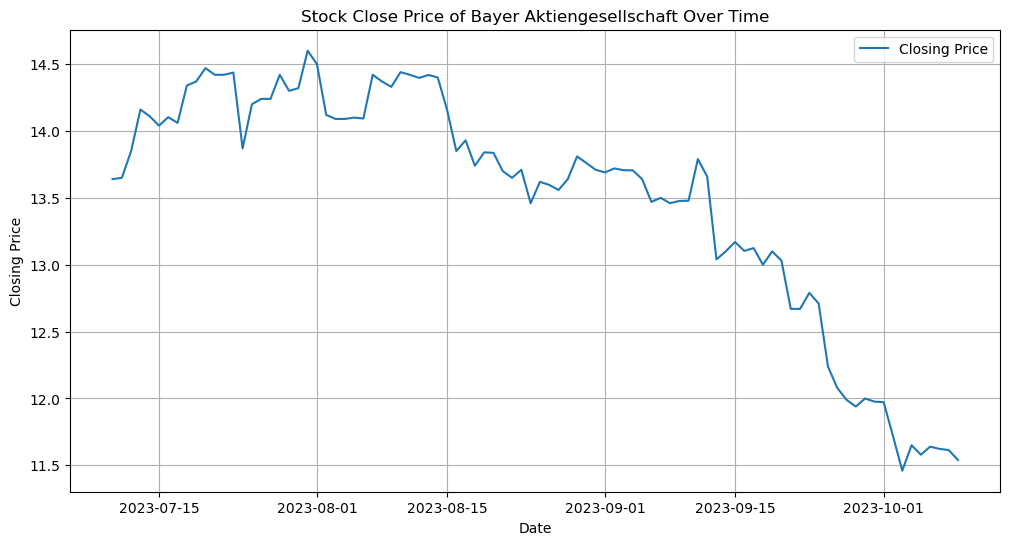

Mean Close Price: 13.50
Median Close Price: 13.71
Standard Deviation of Close Price: 0.88


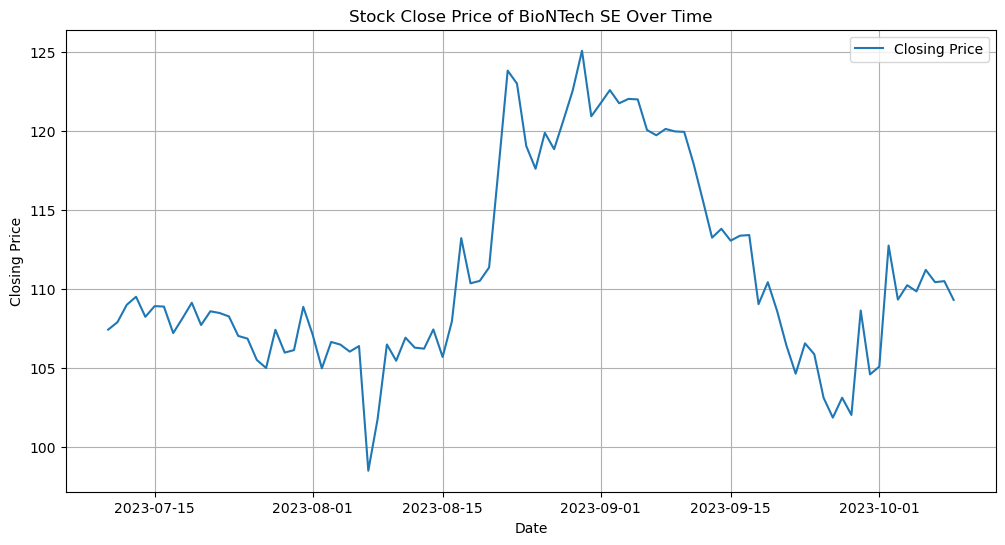

Mean Close Price: 110.97
Median Close Price: 108.90
Standard Deviation of Close Price: 6.24


In [ ]:
# Set the 'Date' column as the index
print(df_BAYRY.columns)
df_BAYRY.set_index('Date', inplace=True)

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df_BAYRY.index, df_BAYRY['Price'], label='Closing Price')
plt.title('Stock Close Price of Bayer Aktiengesellschaft Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate basic statistics
mean_close_price = df_BAYRY['Price'].mean()
median_close_price = df_BAYRY['Price'].median()
std_close_price = df_BAYRY['Price'].std()

print(f"Mean Close Price: {mean_close_price:.2f}")
print(f"Median Close Price: {median_close_price:.2f}")
print(f"Standard Deviation of Close Price: {std_close_price:.2f}")

# Additional analysis and modeling can be performed as needed.


# Set the 'Date' column as the index
df_BNTX.set_index('Date', inplace=True)

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(df_BNTX.index, df_BNTX['Price'], label='Closing Price')
plt.title('Stock Close Price of BioNTech SE Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate basic statistics
mean_close_price = df_BNTX['Price'].mean()
median_close_price = df_BNTX['Price'].median()
std_close_price = df_BNTX['Price'].std()

print(f"Mean Close Price: {mean_close_price:.2f}")
print(f"Median Close Price: {median_close_price:.2f}")
print(f"Standard Deviation of Close Price: {std_close_price:.2f}")

# Additional analysis and modeling can be performed as needed.

# Comparing ROI : If an investor would have invested in the stock on day 1 (say $10,000) what would have been the return on Day 90th? (3 months)

In [ ]:
#Finidng the ROI by using the stock prices at the beggining and end of the data set range
bayr_price_on_july_10 = df_BAYRY.loc['2023-07-10', 'Price']
bayr_price_on_october_9 = df_BAYRY.loc['2023-10-09', 'Price']
number_of_BAyr_share_purchased = (10000/bayr_price_on_july_10)
bayr_value_ofShares_october_9  = number_of_BAyr_share_purchased *bayr_price_on_october_9
rounded_number1 = round(bayr_value_ofShares_october_9, 2)
print("for 10,000$ invested in Bayer Aktiengesellschaf on July 10th, the vlaue at the end of October 9th comes to be:" +str(rounded_number1))

bntx_price_on_july_10 = df_BNTX.loc['2023-07-10', 'Price']
bntx_price_on_october_9 = df_BNTX.loc['2023-10-09', 'Price']
number_of_Bntx_share_purchased = (10000/bntx_price_on_july_10)
bntx_value_ofShares_october_9 = number_of_Bntx_share_purchased * bntx_price_on_october_9
rounded_number2 = round(bntx_value_ofShares_october_9, 2)
print("for 10,000$ invested in BioNTech SE on July 10th, the vlaue at the end of October 9th comes to be:" +str(rounded_number2))

for 10,000$ invested in Bayer Aktiengesellschaf on July 10th, the vlaue at the end of October 9th comes to be:8460.41
for 10,000$ invested in BioNTech SE on July 10th, the vlaue at the end of October 9th comes to be:10175.0


# Checking which stock is more volatile

In [ ]:
#calculating the average "spread" which
bayry_mean_low_price = df_BAYRY['Low'].mean()
bayry_mean_high_price = df_BAYRY['High'].mean()
bayry_spread = bayry_mean_high_price - bayry_mean_low_price
print("The spread of Bayer Aktiengesellschaft stock is " + str(round(bayry_spread,2)))
bntx_mean_low_price = df_BNTX['Low'].mean()
bntx_mean_high_price = df_BNTX['High'].mean()
bntx_spread = bayry_mean_high_price - bayry_mean_low_price
print("The spread of BioNTech SE stock is " + str(round(bntx_spread,2)))

if bayry_spread > bntx_spread :
    print("Bayer Aktiengesellschaft stock is more volatile")

if bayry_spread < bntx_spread :
    print("BioNTech SE stock is more volatile")
else:
    print("Both stocks equally volatile")

The spread of Bayer Aktiengesellschaft stock is 0.16
The spread of BioNTech SE stock is 0.16
Both stocks equally volatile
